## Import Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../Dataset/indo_population_1980-2022_cleaned.csv', parse_dates= ['year'])
df['year'] = df['year'].dt.year

print('Table Structure (Rows, Columns):', df.shape)
df.head()

Table Structure (Rows, Columns): (43, 5)


,year,productive_population,unproductive_population,dependency_ratio,total_population
0,1980,83555877,66765622,79.905357,150321499
1,1981,85684299,67780482,79.104903,153464781
2,1982,87831396,68788744,78.319083,156620140
3,1983,90051324,69731035,77.434769,159782359
4,1984,92426930,70512954,76.290486,162939884


From the Data above, it is showing Indonesia's Productive Population 1980 - 2022.  In the End We Will Forecast the result for 2023 - 2024

## Productive Age Growth Graph (1980 - 2022)

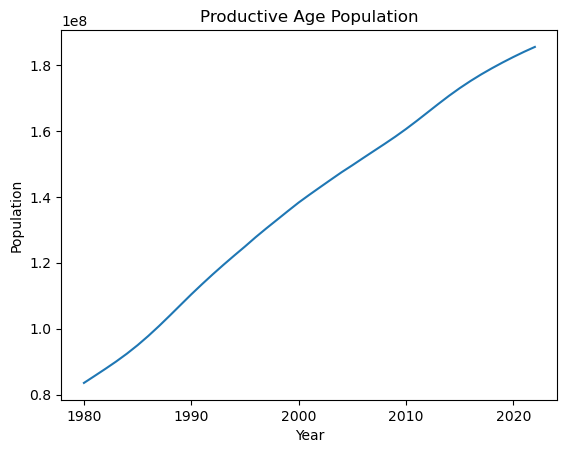

In [2]:
sns.lineplot(data=df, x='year', y='productive_population')
plt.title('Productive Age Population')
plt.xlabel('Year')
plt.ylabel('Population')

plt.show()

## Function to Show List of Difference and P-Value

In [3]:
from statsmodels.tsa.stattools import adfuller

def diff_count(df_col):
    results = {}
    data = df_col
    for i in range (1, 6):
        data = data.diff().dropna()
        adf = adfuller(data)
        p_value = adf[1]
        results[i] = p_value
    
    return results

## Check whether the Data is Stationary or Not

In [4]:
data = df['productive_population']

print(f'P-Value: {adfuller(data)[1]}')

P-Value: 0.21863120292820953


From the result above, data is not Stasionary because from ADF Test, Data P-Value should be below 0.05

## Check How Many Differentiate We Need in Order to Make Data Stasionary

In [5]:
diff_list = diff_count(data)

diff_list

{1: 0.9757341180251115,
 2: 0.00031807031782010394,
 3: 0.002004111758024714,
 4: 1.4618702951469302e-12,
 5: 0.001204486688707297}

From the list above, data will be stationary if we differentiate twice, it will be ARIMA(p,2,q)

## Show Visualization of Stationary Data

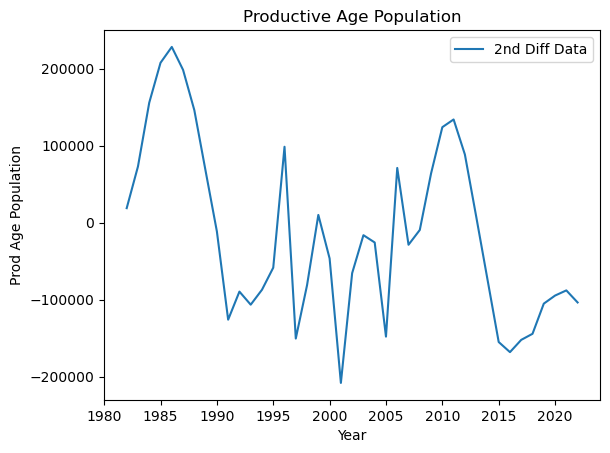

In [6]:
diff_data = data
for i in range(2):
    diff_data = diff_data.diff().dropna()
    
plt.plot(df['year'][2:], diff_data, linestyle='-', label='2nd Diff Data')

plt.xlabel('Year')
plt.ylabel('Prod Age Population')
plt.title('Productive Age Population')
plt.legend()

plt.show()

## Identify The ACF and PACF Graph from Stationary Data

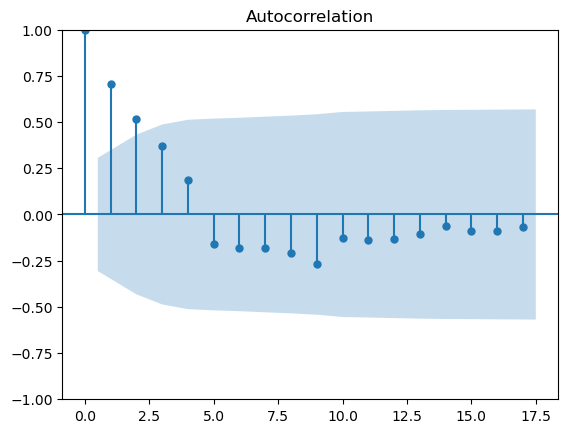

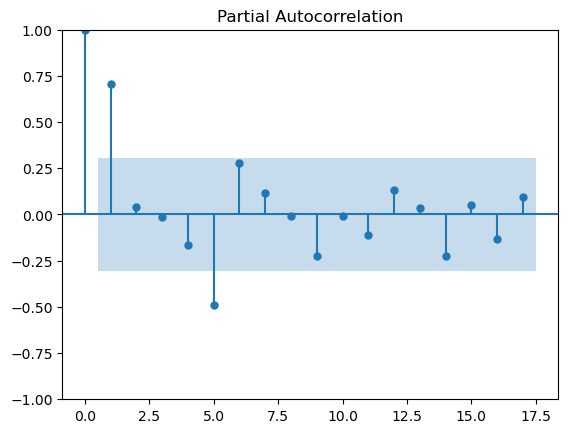

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_diff = plot_acf(diff_data)
pacf_diff = plot_pacf(diff_data)

From the graph above, we can conclude that HyperParameter p & q on ARIMA(p,2,q) will be p = 1 or p = 5, and q = 1 or q = 2

## Determine the Optimal ARIMA Model

In [8]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error
warnings.filterwarnings("ignore")

hyper_param = [(1,2,1), (1,2,2), (5,2,1), (5,2,2)]
for p,d,q in hyper_param:
    model = ARIMA(data, order=(p,d,q))
    pred = model.fit()
    rmse = root_mean_squared_error(data[d:], pred.fittedvalues[d:])
    print(f'RMSE Score untuk ARIMA({p},{d},{q}) {rmse}')

RMSE Score untuk ARIMA(1,2,1) 108351.71533246493
RMSE Score untuk ARIMA(1,2,2) 105025.63546898052
RMSE Score untuk ARIMA(5,2,1) 98319.97154409139
RMSE Score untuk ARIMA(5,2,2) 98270.45603177353


The optimal model is ARIMA(5,2,2)

## Forecast of Productive Age Population 2023-2024

In [9]:
model = ARIMA(data, order=(5,2,2))
pred = model.fit()

productive_population_forecast = pred.forecast(steps=2)

print("Forecasted Values:")
print(productive_population_forecast)

# From Google BiQuery
# 1.86835232e+08
# 1.88125311e+08

# From Linier Regression
# 1.928776e+08
# 1.953769e+08

Forecasted Values:
43    1.869367e+08
44    1.884238e+08
Name: predicted_mean, dtype: float64


## Adding Prediction Result Data to Data Frame

In [10]:
pred_res = pred.fittedvalues

df['productive_population_pred'] = pred_res

df.head()

,year,productive_population,unproductive_population,dependency_ratio,total_population,productive_population_pred
0,1980,83555877,66765622,79.905357,150321499,0.000000e+00
1,1981,85684299,67780482,79.104903,153464781,1.659075e+08
2,1982,87831396,68788744,78.319083,156620140,8.782851e+07
3,1983,90051324,69731035,77.434769,159782359,9.004612e+07
4,1984,92426930,70512954,76.290486,162939884,9.241949e+07


## Extracting Actual Data and Predicted Data from Data Frame

In [11]:
data = df[['year','productive_population']]
data_pred = df[['year','productive_population_pred']]

data.tail()

,year,productive_population
38,2018,178985041
39,2019,180743960
40,2020,182408042
41,2021,183984000
42,2022,185456167


In [12]:
data_pred.tail()

,year,productive_population_pred
38,2018,1.791357e+08
39,2019,1.808572e+08
40,2020,1.825114e+08
41,2021,1.840808e+08
42,2022,1.855684e+08


## Adding 2023 - 2024 Forecast Results to Prediction Data

In [13]:
new_rows = pd.DataFrame({
    'year': [2023, 2024],
    'productive_population_pred': productive_population_forecast
})

data_pred = pd.concat([data_pred, new_rows], ignore_index=True)

data_pred.tail()

,year,productive_population_pred
40,2020,1.825114e+08
41,2021,1.840808e+08
42,2022,1.855684e+08
43,2023,1.869367e+08
44,2024,1.884238e+08


## Visualization of Actual Data and Productive Age Prediction Data (1980 - 2024) Without Ignoring Differentiated Data

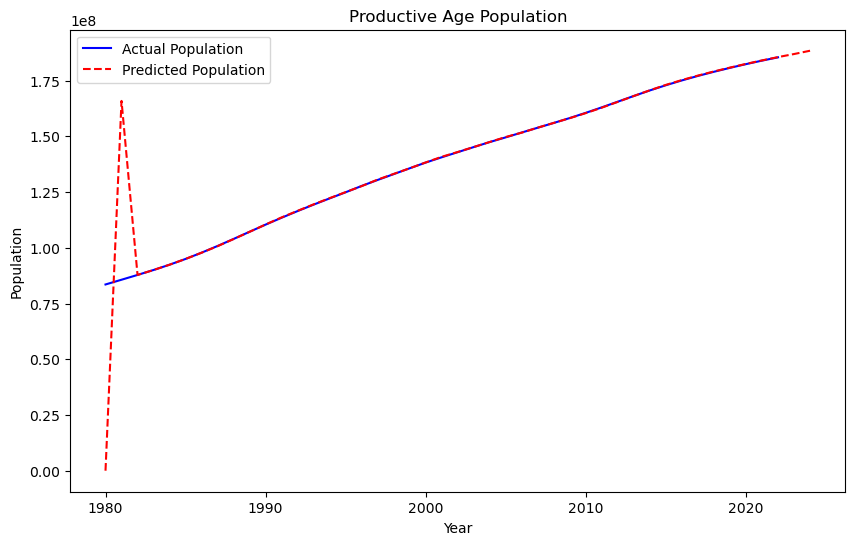

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(data['year'], data['productive_population'], label='Actual Population', color='blue')
plt.plot(data_pred['year'], data_pred['productive_population_pred'], label='Predicted Population', color='red', linestyle='--')

plt.title('Productive Age Population')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()

## Visualization of Actual Data and Productive Age Prediction Data (1980 - 2024) With Ignoring Differentiated Data

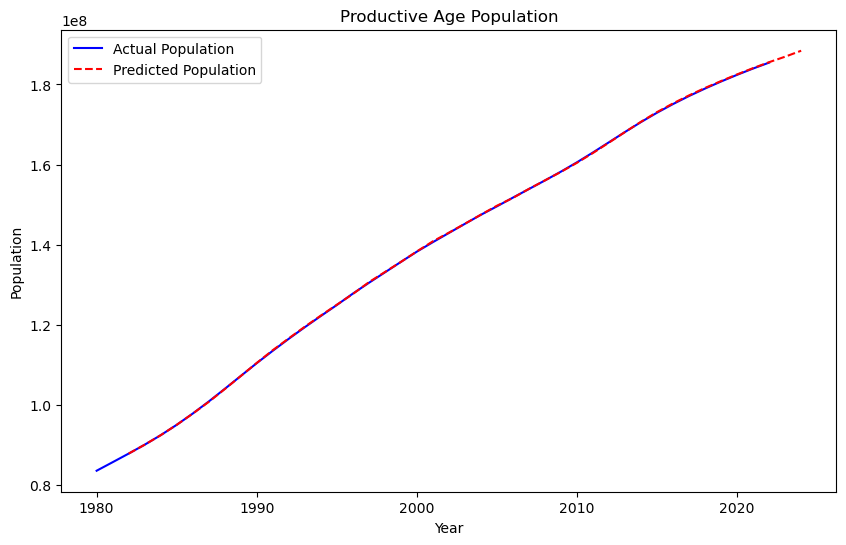

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(data['year'], data['productive_population'], label='Actual Population', color='blue')
plt.plot(data_pred['year'][2:], data_pred['productive_population_pred'][2:], label='Predicted Population', color='red', linestyle='--')

plt.title('Productive Age Population')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()